In [1]:
import logging
import math
import os

logging.basicConfig(level=logging.INFO)
logging.info("library loading")
logging.info("DEBUG")

import torch
import librosa

torch.set_grad_enabled(False)

import cached_conv as cc
import gin
import nn_tilde
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from absl import flags, app

import sys, os
import rave
import rave.model
import rave.blocks
import rave.core
import rave.resampler
from rave.pitch_utils import get_f0_norm, extract_f0_median_std, get_pitch, one_hot, quantize_f0_norm
import IPython.display as ipd

INFO:root:library loading
INFO:root:DEBUG


  [INFO]: device is not None, use cuda:0
  [INFO]    > call by:torchfcpe.tools.spawn_infer_cf_naive_mel_pe_from_pt
  [WARN] args.model.use_harmonic_emb is None; use default False
  [WARN]    > call by:torchfcpe.tools.spawn_cf_naive_mel_pe


In [2]:
run = "excite"

ema_weights = False

cc.use_cached_conv(True)

gin.parse_config_file(os.path.join(run, "config.gin"))
checkpoint = rave.core.search_for_run(run)
print("loading checkpoint:", checkpoint)

pretrained = rave.RAVE()

with open("default.txt", "w") as file:
    for param, val in pretrained.speaker_encoder.state_dict().items():
        file.write(param + "\n")
        file.write(str(val) + "\n")
    
if checkpoint is not None:
    checkpoint = torch.load(checkpoint, map_location='cpu')
    if ema_weights is True and "EMA" in checkpoint["callbacks"]:
        pretrained.load_state_dict(
            checkpoint["callbacks"]["EMA"],
            strict=False,
        )
    else:
        pretrained.load_state_dict(
            checkpoint["state_dict"],
            strict=False,
        )
else:
    print("No checkpoint found, RAVE will remain randomly initialized")

pretrained.eval()

with open("pretrained.txt", "w") as file:
    for param, val in pretrained.speaker_encoder.state_dict().items():
        file.write(param + "\n")
        file.write(str(val) + "\n")

logging.info("warmup pass")
x = torch.zeros(1, 1, 2**14)
pretrained(x)

logging.info("optimize model")

for m in pretrained.modules():
    if hasattr(m, "weight_g"):
        nn.utils.remove_weight_norm(m)

logging.info("script model")

AttributeError: Couldn't resolve selector blocks.GeneratorV2Pitch; <module 'rave.blocks' from '/home/jupyter-arbu/RAVE/rave/blocks.py'> has no attribute GeneratorV2Pitch.
  In file "excite/config.gin", line 72
    blocks.GeneratorV2Pitch.adain = None

In [8]:
my_pqmf = pretrained.pqmf
my_encoder = pretrained.encoder
my_decoder = pretrained.decoder
my_speaker_encoder = pretrained.speaker_encoder
my_excitation_module = pretrained.excitation_module

x, _ = librosa.load("../vctk-small/p225/p225_005_mic1.flac", sr=44100, mono=True)
x = torch.tensor(x[:131072]).unsqueeze(0)
x_mult = torch.ones(x.shape)
ex = my_excitation_module(x, x_mult)
print(ex.shape)

mix = 0.5 * ex[0].numpy() + x[0].numpy()

ipd.display(ipd.Audio(ex[0].numpy(), rate=44100))
ipd.display(ipd.Audio(mix, rate=44100))

torch.Size([1, 131072])


In [2]:
import matplotlib.pyplot as plt

x_len = 2**14
x = torch.zeros(1, 1, x_len)
x_m = my_pqmf(x) 
z = my_encoder(x_m[:, :6, :])

emb_audio, _ = librosa.load("../vctk-small/p225/p225_005_mic1.flac", sr=44100, mono=True)
emb_audio = torch.tensor(emb_audio[:131072]).unsqueeze(0).unsqueeze(1)
emb_audio_pqmf = my_pqmf(torch.tensor(emb_audio))
target_emb = my_speaker_encoder(emb_audio_pqmf).unsqueeze(2)

x, _ = librosa.load("libri.wav", sr=44100, mono=True)
x = torch.tensor(x[:131072]).unsqueeze(0)

mult = torch.ones(x.shape) * 2
ex = my_excitation_module(x, mult).unsqueeze(1)
    
x = my_pqmf(x.unsqueeze(1))
ex_multiband = my_pqmf(ex)

z = my_encoder(x[: ,:6, :])
emb = target_emb.repeat(z.shape[0], 1, z.shape[-1])
z = torch.cat((z, emb), dim=1)
        
y = my_decoder(z, ex_multiband)

y = my_pqmf.inverse(y)
ex = my_pqmf.inverse(ex_multiband)

plt.plot(y[0, 0, :].numpy())

mix = y[0, 0, :].numpy() + ex[0, 0, :].numpy()

ipd.display(ipd.Audio(y[0, 0, :].numpy(), rate=44100))
ipd.display(ipd.Audio(mix, rate=44100))

NameError: name 'my_pqmf' is not defined

In [23]:
run = "runs/test-quickf0_0785598cb0"

ema_weights = False

cc.use_cached_conv(True)

gin.parse_config_file(os.path.join(run, "config.gin"))
checkpoint = rave.core.search_for_run(run)
print("loading checkpoint:", checkpoint)

pretrained = rave.RAVE()

with open("default.txt", "w") as file:
    for param, val in pretrained.speaker_encoder.state_dict().items():
        file.write(param + "\n")
        file.write(str(val) + "\n")
    
if checkpoint is not None:
    checkpoint = torch.load(checkpoint, map_location='cpu')
    if ema_weights is True and "EMA" in checkpoint["callbacks"]:
        pretrained.load_state_dict(
            checkpoint["callbacks"]["EMA"],
            strict=False,
        )
    else:
        pretrained.load_state_dict(
            checkpoint["state_dict"],
            strict=False,
        )
else:
    print("No checkpoint found, RAVE will remain randomly initialized")

pretrained.eval()

with open("pretrained.txt", "w") as file:
    for param, val in pretrained.speaker_encoder.state_dict().items():
        file.write(param + "\n")
        file.write(str(val) + "\n")

logging.info("warmup pass")
test, _ = librosa.load("libri.wav", sr=44100, mono=True)
test = torch.tensor(test[:2**14]).unsqueeze(0).unsqueeze(0)
#x = torch.rand(1, 1, 2**14)
pretrained(test)

logging.info("optimize model")

for m in pretrained.modules():
    if hasattr(m, "weight_g"):
        nn.utils.remove_weight_norm(m)

logging.info("script model")

loading checkpoint: runs/test-quickf0_0785598cb0/version_0/checkpoints/last-v1.ckpt


/opt/tljh/user/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


loaded pretrained speaker embedding


Using cache found in /home/jupyter-arbu/.cache/torch/hub/bshall_hubert_main
INFO:root:warmup pass
INFO:root:optimize model
INFO:root:script model


In [149]:
import numpy as np
from scipy.interpolate import interp1d

def get_f0_norm(y, f0_median, f0_std, fs: int, win_length: int, mult: float=1.0, scale: float=0.0, num_f0_bins: int=256):
    log_f0_norm, f0 = quantize_f0_norm(y, f0_median, f0_std, fs, win_length)
    log_f0_norm += 0.5
    """
    log_f0_norm = log_f0_norm[0].numpy()
    non_nan_indices = np.where(~np.isnan(log_f0_norm))[0]
    non_nan_values = log_f0_norm[non_nan_indices]
    
    # Create an interpolation function
    interp_func = interp1d(non_nan_indices, non_nan_values, kind='cubic', fill_value='extrapolate')
    
    # Identify the indices of the NaN entries
    nan_indices = np.where(np.isnan(log_f0_norm))[0]
    
    # Interpolate the NaN entries
    log_f0_norm[nan_indices] = interp_func(nan_indices)

    log_f0_norm = log_f0_norm * mult + scale
    """
    #log_f0_norm = torch.linspace(1, 0, log_f0_norm.shape[-1]).to(y) 
    #log_f0_norm = torch.ones(log_f0_norm.shape) * 0.7
    #log_f0_norm = torch.tensor(log_f0_norm).unsqueeze(0)
    log_f0_norm = log_f0_norm * mult + scale
    #log_f0_norm = torch.linspace(0, 1, log_f0_norm.shape[-1]).unsqueeze(0)
    bins = torch.linspace(0, 1, num_f0_bins+1).to(y) 
    f0_one_hot_idxs = torch.bucketize(log_f0_norm, bins, right=True) - 1
    f0_one_hot = one_hot(f0_one_hot_idxs, num_f0_bins+1)
    return f0_one_hot, log_f0_norm

In [5]:
def nanstd(o, dim, keepdim=False):
    result = torch.sqrt(
                    torch.nanmean(
                        torch.pow( torch.abs(o-torch.nanmean(o,dim=dim).unsqueeze(dim)),2),
                        dim=dim
                    )
                )
    if keepdim:
        result = result.unsqueeze(dim)
    return result

/tmp/ipykernel_2189661/2046600180.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb_audio_pqmf = my_pqmf(torch.tensor(emb_audio.unsqueeze(1)))


torch.Size([1, 262144]) torch.Size([1, 131072])


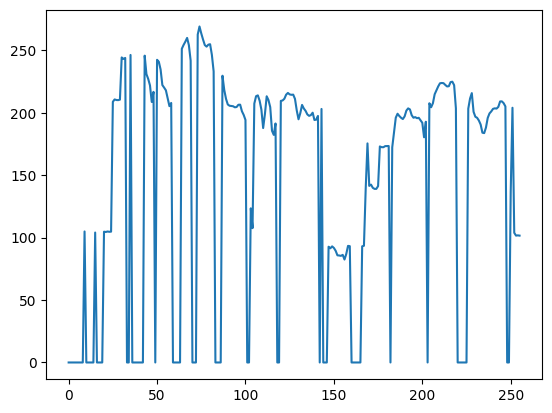

In [81]:
my_pqmf = pretrained.pqmf
my_encoder = pretrained.encoder
my_decoder = pretrained.decoder
my_speaker_encoder = pretrained.speaker_encoder

emb_audio, _ = librosa.load("../vctk-small/p228/p228_005_mic1.flac", sr=44100, mono=True)
emb_audio = torch.tensor(emb_audio[:131072]).unsqueeze(0)
emb_audio_pqmf = my_pqmf(torch.tensor(emb_audio.unsqueeze(1)))
target_emb = my_speaker_encoder(emb_audio_pqmf).unsqueeze(2)

x, _ = librosa.load("../vctk-small/p228/p228_005_mic1.flac", sr=44100, mono=True)
x = torch.tensor(x[:2*131072]).unsqueeze(0)

f0_target_length=(x.shape[-1] // 1024)

print(x.shape, emb_audio.shape)
f0 = pitch_model.infer(x.unsqueeze(-1),
                         sr=44100,
                         decoder_mode='local_argmax',
                         threshold=0.006,
                         f0_min=50,
                         f0_max=550,
                         interp_uv=False,
                         output_interp_target_length=f0_target_length)


f0_stats = f0.clone()
f0_stats[f0_stats == 0] = float('nan')
mean = torch.nanmean(f0_stats, dim=1, keepdim=True)
std = nanstd(f0_stats, dim=1, keepdim=True)

f0 = f0 * 1.0
plt.plot(f0[0, :, 0].cpu())

f0_norm = (f0 - mean) / std
f0_norm[torch.isnan(f0_norm)] = 0
        
#f0_norm, log_f0_norm = get_f0_norm(batch[0], medians, stds, 44100, 1024)
f0_norm = torch.permute(f0_norm, (0, 2, 1))
x_multiband = my_pqmf(x.unsqueeze(1))
z = my_encoder(x_multiband[:, :6, :])

with torch.no_grad():
    emb = my_speaker_encoder(x_multiband).unsqueeze(2)

emb = emb.repeat(1, 1, z.shape[-1])
        
y = my_decoder(torch.cat((z.detach(), emb, f0_norm.cpu()), dim=1))
y = my_pqmf.inverse(y)
ipd.display(ipd.Audio(y[0, 0, :].numpy(), rate=44100))

  [INFO]: device is not None, use cuda:0
  [INFO]    > call by:torchfcpe.tools.spawn_infer_cf_naive_mel_pe_from_pt
  [WARN] args.model.use_harmonic_emb is None; use default False
  [WARN]    > call by:torchfcpe.tools.spawn_cf_naive_mel_pe


/tmp/ipykernel_2189661/436730008.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb_audio_pqmf = my_pqmf(torch.tensor(emb_audio.unsqueeze(1)))


torch.Size([1, 1, 128])
tensor([[[209.8280]]], device='cuda:0') tensor([[[41.2947]]], device='cuda:0')
torch.Size([1, 64, 128]) torch.Size([1, 256, 128]) torch.Size([1, 1, 128]) torch.Size([1, 128, 1])
torch.Size([1, 321, 128])


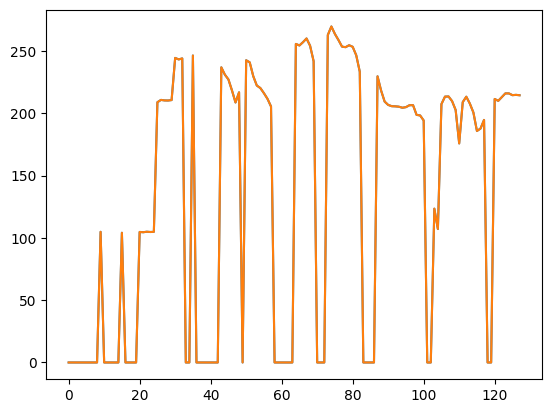

In [72]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
from  scipy.io import wavfile 
from torchfcpe import spawn_bundled_infer_model
pitch_model = spawn_bundled_infer_model(device="cuda:0")

my_pqmf = pretrained.pqmf
my_encoder = pretrained.encoder
my_decoder = pretrained.decoder
my_speaker_encoder = pretrained.speaker_encoder

emb_audio, _ = librosa.load("../vctk-small/p228/p228_005_mic1.flac", sr=44100, mono=True)
emb_audio = torch.tensor(emb_audio[:131072]).unsqueeze(0)
emb_audio_pqmf = my_pqmf(torch.tensor(emb_audio.unsqueeze(1)))
target_emb = my_speaker_encoder(emb_audio_pqmf).unsqueeze(2)

x, _ = librosa.load("../vctk-small/p228/p228_005_mic1.flac", sr=44100, mono=True)
x = torch.tensor(x[:131072]).unsqueeze(0)

src_f0_median, src_f0_std = extract_f0_median_std(
            x,
            44100,
            1024
        )

#src_f0_median = src_f0_median.unsqueeze(0).repeat(x.shape[0], 1)
#src_f0_std = src_f0_std.unsqueeze(0).repeat(x.shape[0], 1)
        
#f0_norm, log_f0_norm = get_f0_norm(x, src_f0_median, src_f0_std, 44100, 1024)
#np.savetxt('tens.txt', f0_norm[0, :].numpy())
#f0_norm = torch.permute(f0_norm, (0, 2, 1))
f0_in_length=(x.shape[-1] // 1024)

f0_in = pitch_model.infer(x.unsqueeze(-1),
                         sr=44100,
                         decoder_mode='local_argmax',
                         threshold=0.006,
                         f0_min=50,
                         f0_max=550,
                         interp_uv=False,
                         output_interp_target_length=f0_in_length)

f0_tar = pitch_model.infer(emb_audio.unsqueeze(-1),
                         sr=44100,
                         decoder_mode='local_argmax',
                         threshold=0.006,
                         f0_min=50,
                         f0_max=550,
                         interp_uv=False,
                         output_interp_target_length=f0_in_length)

f0_stats_inp = f0_in.clone()
f0_stats_inp[f0_stats_inp == 0] = float('nan')
mean_in = torch.nanmean(f0_stats_inp, dim=1, keepdim=True)
std_in = nanstd(f0_stats_inp, dim=1, keepdim=True)

f0_stats_tar = f0_tar.clone()
f0_stats_tar[f0_stats_tar == 0] = float('nan')
mean_tar = torch.nanmean(f0_stats_tar, dim=1, keepdim=True)
std_tar = nanstd(f0_stats_tar, dim=1, keepdim=True)

standardized_source_pitch = (f0_in - mean_in) / std_in
source_pitch = (standardized_source_pitch * std_tar + mean_tar)
source_pitch[torch.isnan(source_pitch)] = 0

f0_norm = torch.permute(source_pitch, (0, 2, 1))

print(f0_norm.shape)

print(mean_in, std_in)
plt.plot(f0_norm[0, 0, :].cpu().numpy())
plt.plot(f0_in[0, :, 0].cpu().numpy())

x_in = x.unsqueeze(1)
x_in = my_pqmf(x_in)

z = my_encoder(x_in[: , :6, :])
emb = target_emb.repeat(z.shape[0], 1, z.shape[-1])

print(z.shape, emb.shape, f0_norm.shape, f0_in.shape)
z = torch.cat((z, emb, f0_norm.cpu()), dim=1)
print(z.shape)

y = my_decoder(z)
y = my_pqmf.inverse(y)

k = y[0, 0, :].numpy()

ipd.display(ipd.Audio(y[0, 0, :].numpy(), rate=44100))
ipd.display(ipd.Audio(x[0, :].numpy(), rate=44100))

#wavfile.write('pitch_high.wav', 44100, k)

torch.Size([8, 257])
torch.Size([1, 257])


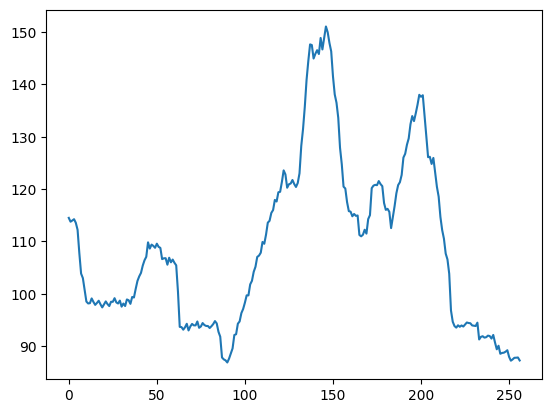

In [184]:
import torchcrepe

x, _ = librosa.load("libri.wav", sr=44100, mono=True)
x = torch.tensor(x[:2*131072]).unsqueeze(0)
x = x.repeat(8, 1)

fmin = 50
fmax = 550
model = 'tiny'
device = 'cuda:0'
batch_size = 2048

batch_results = []
for i in range(len(x)):
    pitch = torchcrepe.predict(x[i].unsqueeze(0),
                           44100,
                           1024,
                           fmin,
                           fmax,
                           model,
                           batch_size=batch_size,
                           device=device)
    batch_results.append(pitch)
result = torch.stack(batch_results, dim=0).float().squeeze(1)
print(result.shape)

print(pitch.shape)
plt.plot(result[3])

(690,)
(211,)
torch.Size([1, 1, 128])


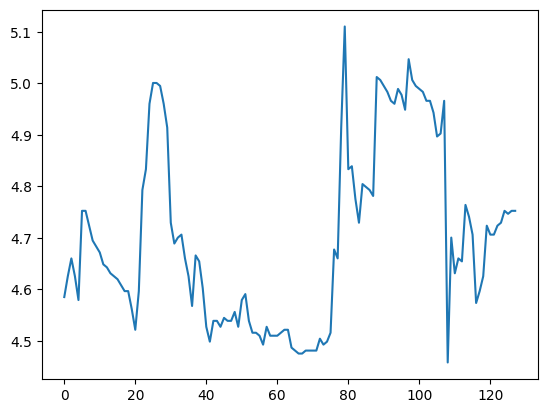

In [9]:
def extract_utterance_log_f0(y, sr, frame_len_samples, hop_len_samples, voiced_prob_cutoff=0.2):
    f0, voiced_flag, voiced_probs = librosa.pyin(
        y,
        fmin=librosa.note_to_hz('C2'),
        fmax=librosa.note_to_hz('C5'),
        sr=sr,
        frame_length=frame_len_samples,
        hop_length=hop_len_samples,
        n_thresholds=5
    )

    f0[np.where(voiced_probs < voiced_prob_cutoff)] = np.nan
    log_f0 = np.log(f0)

    return log_f0


x, fs = librosa.load("libri.wav", sr=44100, mono=True)
x = x[:4 * fs]
f0_vals = extract_utterance_log_f0(
                x, fs, 1024, 256, 0.1
            )

print(f0_vals.shape)
f0_vals = f0_vals[~np.isnan(f0_vals)]
print(f0_vals.shape)
#plt.plot(f0_vals)

f0_vals_t = torch.tensor(f0_vals).unsqueeze(0).unsqueeze(0)

f0_vals_t = nn.functional.interpolate(f0_vals_t, size=128)
print(f0_vals_t.shape)

plt.plot(f0_vals_t[0, 0, :])

ipd.display(ipd.Audio(x, rate=44100))

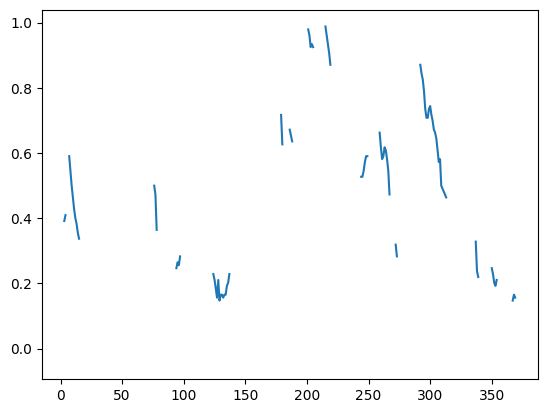

In [32]:
def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])


def quantize(value, bins, num_bins):
    one_hot_idx = np.minimum(np.digitize(value, bins)-1, num_bins-1)
    one_hot_representation = one_hot(one_hot_idx, num_bins).astype(np.float32)
    return one_hot_representation


def extract_utterance_log_f0(y, sr, frame_len_samples, hop_len_samples, voiced_prob_cutoff=0.2):
    f0, voiced_flag, voiced_probs = librosa.pyin(
        y,
        fmin=librosa.note_to_hz('C2'),
        fmax=librosa.note_to_hz('C5'),
        sr=sr,
        frame_length=frame_len_samples,
        hop_length=hop_len_samples,
        n_thresholds=5
    )

    f0[np.where(voiced_probs < voiced_prob_cutoff)] = np.nan
    log_f0 = np.log(f0)

    return log_f0


def quantize_f0_norm(y, f0_median, f0_std, fs, win_length, hop_length):
    utt_log_f0 = extract_utterance_log_f0(y, fs, win_length, hop_length)
    log_f0_norm = ((utt_log_f0 - f0_median) / f0_std) / 4.0

    return log_f0_norm


def get_f0_norm(y, f0_median, f0_std, fs, win_length, hop_length, num_f0_bins=256):
    log_f0_norm = quantize_f0_norm(y, f0_median, f0_std, fs, win_length, hop_length) + 0.5

    plt.plot(log_f0_norm)

    bins = np.linspace(0, 1, num_f0_bins+1)
    f0_one_hot_idxs = np.digitize(log_f0_norm, bins) - 1
    f0_one_hot = one_hot(f0_one_hot_idxs, num_f0_bins+1)

    return f0_one_hot


def extract_f0_median_std(wav, fs, win_length, hop_length):
    log_f0_vals = extract_utterance_log_f0(wav, fs, win_length, hop_length)
    log_f0_vals = log_f0_vals[~np.isnan(log_f0_vals)]

    log_f0_median = np.median(log_f0_vals).astype(np.float32)
    log_f0_std = np.std(log_f0_vals).astype(np.float32)

    return log_f0_median, log_f0_std

hop_length = 256
win_length = 1024

sec = 6

x, fs = librosa.load("libri.wav", sr=16000, mono=True)
x = x[:sec * fs]

med, std = extract_f0_median_std(x, fs, win_length=win_length, hop_length=hop_length)
f0_norm = get_f0_norm(x, med, std, fs, win_length=win_length, hop_length=hop_length)

tensor([4.7488]) tensor([0.1663])


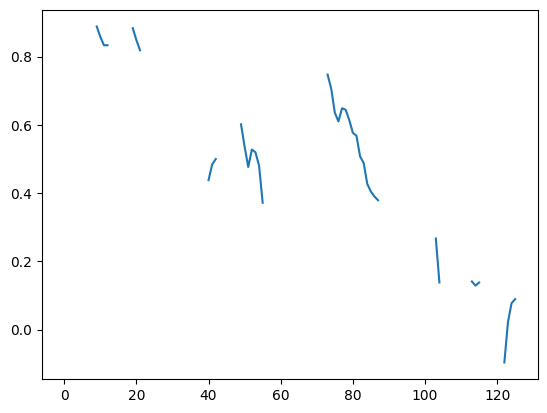

In [7]:
import matplotlib.pyplot as plt
import IPython.display as ipd
from rave.pitch_utils import get_f0_norm, extract_f0_median_std

my_input, _ = librosa.load("libri.wav", sr=44100, mono=True)
my_input = my_input[131072:(2*131072)]
ipd.display(ipd.Audio(my_input, rate=44100, normalize=True))
my_input_t = torch.tensor(my_input).unsqueeze(0)

block = 1024

src_f0_median, src_f0_std = extract_f0_median_std(
            my_input_t,
            44100,
            block,
            block
        )

src_f0_median = src_f0_median.unsqueeze(0)
src_f0_std = src_f0_std.unsqueeze(0)

print(src_f0_median, src_f0_std)
        
f0_norm, log_f0_norm, f0 = get_f0_norm(my_input_t, src_f0_median, src_f0_std, 44100, block, block)

f0 = f0[0].numpy() 
plt.plot(log_f0_norm[0])

f0_norm = torch.permute(f0_norm, (0, 2, 1))

f = np.repeat(f0, -(-len(my_input) // len(f0)))
y_p = np.sin(2 * np.pi * (np.cumsum(f / 44100) % 1.0))[:len(my_input)]

y_mix = y_p + 0.5 * my_input_t.numpy()

ipd.display(ipd.Audio(y_p, rate=44100))
ipd.display(ipd.Audio(y_mix, rate=44100))